# Outline

* [Setup](#setup)
* [MyNN](#mynn)
* [Pytorch](#pytorch)
* [Keras](#keras)
* [Tensforflow](#tensorflow)

# Setup <a class='anchor' id='setup'></a>

In [1]:
import matplotlib.pyplot as plt

def plot_train_log(log, to_epoch=False, from_epoch=1):
    assert (from_epoch >= 1 and (to_epoch is False or to_epoch > from_epoch)), 'invalid epoch range'
    '''plots log = {'loss':[...], 'accuracy':[...], 'val_loss':[...], 'val_accuracy':[...]}
    '''
    to_epoch = len(log['loss'])+1 if not to_epoch else to_epoch+1
    epochs = np.arange(from_epoch, to_epoch)
    from_epoch -=1
    to_epoch -= 1
    
    # following values are used to annotate the dashed lines
    val_loss_min = min(log['val_loss'][from_epoch: to_epoch])
    val_loss_mine = np.argmin(log['val_loss'][from_epoch: to_epoch]) + from_epoch
    val_accuracy_max = max(log['val_accuracy'][from_epoch: to_epoch])
    val_accuracy_maxe = np.argmax(log['val_accuracy'][from_epoch: to_epoch]) + from_epoch    
    
    fig, axes = plt.subplots(1,2, figsize=(14, 4))
    axes[0].plot(epochs, log['loss'][from_epoch: to_epoch], label='train')
    axes[0].plot(epochs, log['val_loss'][from_epoch: to_epoch], label='validation', alpha=0.8)
    
    axes[0].axhline(y=val_loss_min, color='g', alpha=0.4, linestyle='--')
    axes[0].text(epochs[-1], val_loss_min, round(val_loss_min, 2), weight='bold',
                 color='w', backgroundcolor='g', size='smaller')
    axes[0].axvline(x=val_loss_mine, color='y', alpha=0.4, linestyle='--')
    ypos = max(np.max(log['val_loss'][from_epoch: to_epoch]), np.max(log['loss'][from_epoch: to_epoch]))
    axes[0].text(val_loss_mine, ypos, val_loss_mine, weight='bold',
                 color='w', backgroundcolor='y', size='smaller')
    
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].legend()
    axes[1].plot(epochs, log['accuracy'][from_epoch: to_epoch], label='train')
    axes[1].plot(epochs, log['val_accuracy'][from_epoch: to_epoch], label='validation', alpha=0.8)
    
    axes[1].axhline(y=val_accuracy_max, color='g', alpha=0.4, linestyle='--')
    axes[1].text(epochs[-1], val_accuracy_max, round(val_accuracy_max, 2), weight='bold',
                 color='w', backgroundcolor='g', size='smaller')
    axes[1].axvline(x=val_accuracy_maxe, color='y', alpha=0.4, linestyle='--')
    ypos = max(np.max(log['val_accuracy'][from_epoch: to_epoch]), np.max(log['accuracy'][from_epoch: to_epoch]))
    axes[1].text(val_accuracy_maxe, ypos, val_accuracy_maxe, weight='bold',
                 color='w', backgroundcolor='y', size='smaller')
    
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].legend()
    plt.show()

https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def load_catvnoncat_data():
    import h5py
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


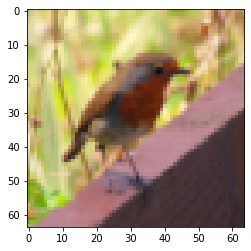

y = 0. It's a non-cat picture.


In [4]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
plt.show()
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

# MyNN <a class='anchor' id='mynn'></a>

In [5]:
from network import NN

In [6]:
def fit(trainer, print_epochs):
    log = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}
    for i, cost in enumerate(trainer, 1):
        log['loss'].append(cost.item())

        pred_y = net.predict(train_x)    
        acc = np.sum(pred_y == train_y)/train_y.shape[1]
        log['accuracy'].append(acc)

        pred_y = net.predict(test_x)
        val_acc = np.sum(pred_y == test_y)/test_y.shape[1]
        log['val_accuracy'].append(val_acc)

        pred_y_prob = net.predict_proba(test_x)    
        val_loss = 1/test_y.shape[1] * np.sum(NN.LOGLOSS(pred_y_prob, test_y), axis=1)
        log['val_loss'].append(val_loss.item())

        if i % print_epochs == 0:
            print(f'{i}. \t'
                  f'accuracy: {acc:.4f} - loss: {cost.item():.3f} -- ' 
                  f'val_accuracy: {val_acc:.4f} - val_loss: {val_loss.item():.3f}')
    return log

## Cat vs. not Cat example

200. 	accuracy: 0.8325 - loss: 0.444 -- val_accuracy: 0.6000 - val_loss: 0.650
400. 	accuracy: 0.8900 - loss: 0.363 -- val_accuracy: 0.6400 - val_loss: 0.623
600. 	accuracy: 0.9043 - loss: 0.311 -- val_accuracy: 0.7200 - val_loss: 0.622
800. 	accuracy: 0.9426 - loss: 0.273 -- val_accuracy: 0.7400 - val_loss: 0.630
1000. 	accuracy: 0.9569 - loss: 0.244 -- val_accuracy: 0.7400 - val_loss: 0.643
1200. 	accuracy: 0.9713 - loss: 0.221 -- val_accuracy: 0.7400 - val_loss: 0.657
1400. 	accuracy: 0.9713 - loss: 0.202 -- val_accuracy: 0.7400 - val_loss: 0.672
1600. 	accuracy: 0.9761 - loss: 0.186 -- val_accuracy: 0.7200 - val_loss: 0.687
1800. 	accuracy: 0.9761 - loss: 0.172 -- val_accuracy: 0.7200 - val_loss: 0.702
2000. 	accuracy: 0.9761 - loss: 0.160 -- val_accuracy: 0.7200 - val_loss: 0.717


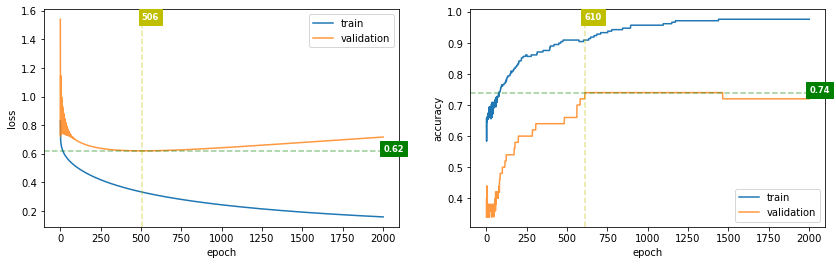

Wall time: 15.8 s


In [7]:
%%time
net = NN([1], [NN.SIGMOID], loss_func=NN.LOGLOSS)
trainer = net.train(train_x, train_y, alpha=0.004, max_iterations=2000, return_cost_every=1)
log = fit(trainer, print_epochs=200)
plot_train_log(log)

200. 	accuracy: 0.7990 - loss: 0.476 -- val_accuracy: 0.5400 - val_loss: 0.667
400. 	accuracy: 0.8612 - loss: 0.402 -- val_accuracy: 0.6200 - val_loss: 0.631
600. 	accuracy: 0.8947 - loss: 0.352 -- val_accuracy: 0.6400 - val_loss: 0.621
800. 	accuracy: 0.9043 - loss: 0.316 -- val_accuracy: 0.7200 - val_loss: 0.622
1000. 	accuracy: 0.9330 - loss: 0.287 -- val_accuracy: 0.7400 - val_loss: 0.627
1200. 	accuracy: 0.9522 - loss: 0.264 -- val_accuracy: 0.7400 - val_loss: 0.635
1400. 	accuracy: 0.9569 - loss: 0.245 -- val_accuracy: 0.7400 - val_loss: 0.645
1600. 	accuracy: 0.9713 - loss: 0.229 -- val_accuracy: 0.7400 - val_loss: 0.655
1800. 	accuracy: 0.9713 - loss: 0.215 -- val_accuracy: 0.7400 - val_loss: 0.666
2000. 	accuracy: 0.9761 - loss: 0.203 -- val_accuracy: 0.7200 - val_loss: 0.677


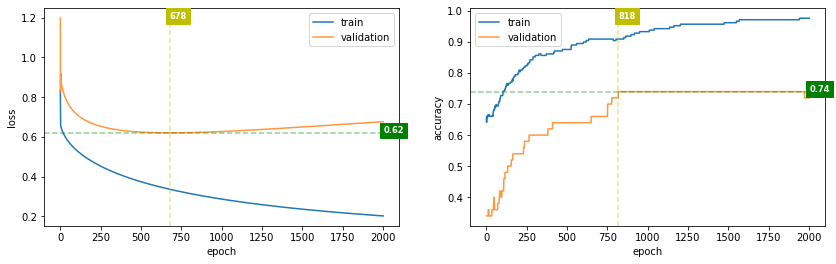

In [8]:
net = NN([1], [NN.SIGMOID], loss_func=NN.LOGLOSS)
trainer = net.train(train_x, train_y, alpha=0.003, max_iterations=2000, lambd=1.0, return_cost_every=1)
log = fit(trainer, print_epochs=200)
plot_train_log(log)

# Pytorch <a class='anchor' id='pytorch'></a>

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

## Cat vs. not Cat example

In [10]:
class DataCatvsnonCat(Dataset):
    def __init__(self, test=False):
        train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_catvnoncat_data()
        
        # Reshape the training and test examples 
        train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
        test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

        # Standardize data to have feature values between 0 and 1.
        train_x = train_x_flatten/255.
        train_y = train_set_y_orig.T
        test_x = test_x_flatten/255.
        test_y = test_set_y_orig.T
        if not test:
            self.x = train_x
            self.y = train_y
        else:
            self.x = test_x
            self.y = test_y
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.y)

In [11]:
train_data = DataCatvsnonCat()
test_data = DataCatvsnonCat(test=True)
train_loader = DataLoader(dataset=train_data, batch_size=len(train_data), shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=len(test_data))

    note: train_loader.dataset is train_data

In [12]:
class TorchNet(torch.nn.Module):
    
    functions = {'relu': torch.relu, 'sigmoid': torch.sigmoid}
    
    def __init__(self, D_in, layers):
        super().__init__()
        assert (len([fstr for _, fstr in layers if fstr not in self.functions]) == 0), 'invalid activation function'        
        self.linears = torch.nn.ModuleList() # this way all linears are registered and parameters are assigned
        self.activations = []
        for D_out, fstr in layers:            
            self.linears.append(torch.nn.Linear(D_in, D_out))
            self.activations.append(self.functions[fstr])
            D_in = D_out        
        
    def forward(self, x):        
        for activation, linear in zip(self.activations, self.linears):
            x = activation(linear(x))
        return x
    
    def __repr__(self):
        return str(list(zip(self.linears, [f.__name__ for f  in self.activations])))

In [13]:
tnet1 = TorchNet(12288, [(20, 'relu'), (7, 'relu'), (5, 'relu'), (1, 'sigmoid')])
tnet2 = torch.nn.Sequential(torch.nn.Linear(12288, 20), torch.nn.ReLU(),
                            torch.nn.Linear(20, 7), torch.nn.ReLU(), 
                            torch.nn.Linear(7, 5), torch.nn.ReLU(), 
                            torch.nn.Linear(5, 1), torch.nn.Sigmoid())

print('tnet1:\n', tnet1)
print()
print('tnet2:\n', tnet2)

tnet1:
 [(Linear(in_features=12288, out_features=20, bias=True), 'relu'), (Linear(in_features=20, out_features=7, bias=True), 'relu'), (Linear(in_features=7, out_features=5, bias=True), 'relu'), (Linear(in_features=5, out_features=1, bias=True), 'sigmoid')]

tnet2:
 Sequential(
  (0): Linear(in_features=12288, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
  (7): Sigmoid()
)


In [14]:
def train(train_loader, validation_loader, model, criterion, optimizer, epochs, terminate_loss = 0, print_epochs=False):    
    log = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}
    train_size, validation_size = len(train_loader.dataset), len(validation_loader.dataset)
    
    for i, epoch in enumerate(range(epochs), 1):        
        
        model.train()
        
        correct = 0
        totloss = 0.0
        for x, y in train_loader:            
            optimizer.zero_grad()
            yhat = model(x) # careful: yhat is the output of last activation function
            loss = criterion(yhat, y)            
            loss.backward()
            optimizer.step()            
            totloss += loss.data.item()
            correct += torch.sum(yhat.round() == y).item()
        log['accuracy'].append(correct / train_size)
        log['loss'].append(totloss * train_loader.batch_size / train_size)
        
        model.eval()
        
        correct = 0
        totloss = 0.0        
        for x,y in validation_loader:            
            with torch.no_grad():
                yhat = model(x)                
                loss = criterion(yhat, y)
                totloss += loss.data.item()
                correct += torch.sum(yhat.round() == y).item()
        log['val_accuracy'].append(correct / validation_size)
        log['val_loss'].append(totloss * validation_loader.batch_size / validation_size)
        
        if print_epochs and i % print_epochs == 0:
            print('Epoch  {}\t loss: {:.4f} - accuracy: {:.4f} -- val_loss: {:.4f} - val_accuracy: {:.4f}'
                  .format(i, log['loss'][-1], log['accuracy'][-1], 
                          log['val_loss'][-1], log['val_accuracy'][-1]))
        if log['loss'][-1] <= terminate_loss and log['val_loss'][-1] <= terminate_loss:
            break
    return log

Epoch  50	 loss: 0.3435 - accuracy: 0.8804 -- val_loss: 0.5914 - val_accuracy: 0.7200
Epoch  100	 loss: 0.2031 - accuracy: 0.9713 -- val_loss: 0.6947 - val_accuracy: 0.7200
Epoch  150	 loss: 0.1374 - accuracy: 0.9904 -- val_loss: 0.7763 - val_accuracy: 0.7000
Epoch  200	 loss: 0.0983 - accuracy: 0.9952 -- val_loss: 0.8610 - val_accuracy: 0.7000
Epoch  250	 loss: 0.0737 - accuracy: 0.9952 -- val_loss: 0.9383 - val_accuracy: 0.7000
Epoch  300	 loss: 0.0573 - accuracy: 1.0000 -- val_loss: 1.0068 - val_accuracy: 0.7000
Epoch  350	 loss: 0.0459 - accuracy: 1.0000 -- val_loss: 1.0678 - val_accuracy: 0.7000
Epoch  400	 loss: 0.0377 - accuracy: 1.0000 -- val_loss: 1.1223 - val_accuracy: 0.7000


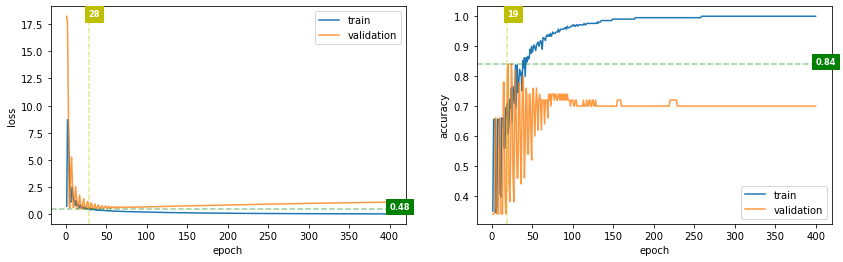

Wall time: 10.1 s


In [15]:
%%time
tnet1 = TorchNet(12288, [(1, 'sigmoid')])
# tnet1 = TorchNet(12288, [(10, 'relu'), (5, 'relu'), (1, 'sigmoid')])
optimizer = torch.optim.Adam(tnet1.parameters(), lr=0.005) # very sensitive to learning rate
criterion = torch.nn.BCELoss()
log = train(train_loader, test_loader, tnet1, criterion, optimizer, epochs=400, print_epochs=50, terminate_loss=0.4)

plot_train_log(log)

Epoch  100	 loss: 0.4270 - accuracy: 0.8612 -- val_loss: 0.6277 - val_accuracy: 0.6400
Epoch  200	 loss: 0.3378 - accuracy: 0.9091 -- val_loss: 0.6074 - val_accuracy: 0.6800
Epoch  300	 loss: 0.2833 - accuracy: 0.9330 -- val_loss: 0.6145 - val_accuracy: 0.7400
Epoch  400	 loss: 0.2450 - accuracy: 0.9569 -- val_loss: 0.6298 - val_accuracy: 0.7400
Epoch  500	 loss: 0.2161 - accuracy: 0.9713 -- val_loss: 0.6481 - val_accuracy: 0.7200
Epoch  600	 loss: 0.1934 - accuracy: 0.9713 -- val_loss: 0.6673 - val_accuracy: 0.7000
Epoch  700	 loss: 0.1750 - accuracy: 0.9761 -- val_loss: 0.6867 - val_accuracy: 0.7000
Epoch  800	 loss: 0.1597 - accuracy: 0.9761 -- val_loss: 0.7057 - val_accuracy: 0.7000
Epoch  900	 loss: 0.1468 - accuracy: 0.9856 -- val_loss: 0.7241 - val_accuracy: 0.7000
Epoch  1000	 loss: 0.1357 - accuracy: 0.9904 -- val_loss: 0.7419 - val_accuracy: 0.7000


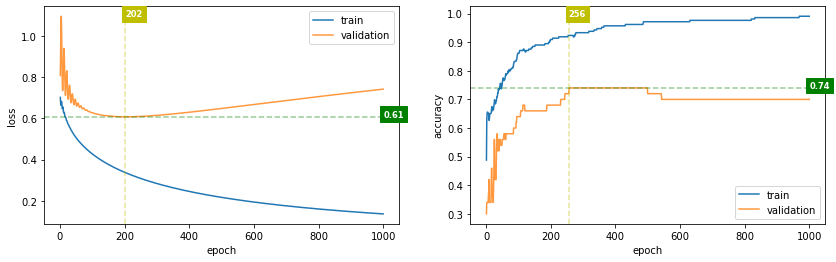

Wall time: 23.6 s


In [16]:
%%time
tnet2 = torch.nn.Sequential(torch.nn.Linear(12288, 1), torch.nn.Sigmoid())
optimizer = torch.optim.SGD(tnet2.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.BCELoss()
log = train(train_loader, test_loader, tnet2, criterion, optimizer, epochs=1000, print_epochs=100)

plot_train_log(log)

# Keras <a class='anchor' id='keras'></a>

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Cat vs. not Cat example

In [6]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
train_y = train_y.T
test_y = test_y.T
assert( train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0])

print ("train_x's shape: ", train_x.shape)
print ("test_x's shape: ", test_x.shape)

train_x's shape:  (209, 12288)
test_x's shape:  (50, 12288)


In [30]:
num_pixels = train_x.shape[1]

model = Sequential()

# model.add(Dense(20, activation='relu', input_shape=(num_pixels, )))
# model.add(Dense(7, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid', input_shape=(num_pixels, )))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')

In [31]:
%%time
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=500, verbose=0)

Wall time: 22.1 s


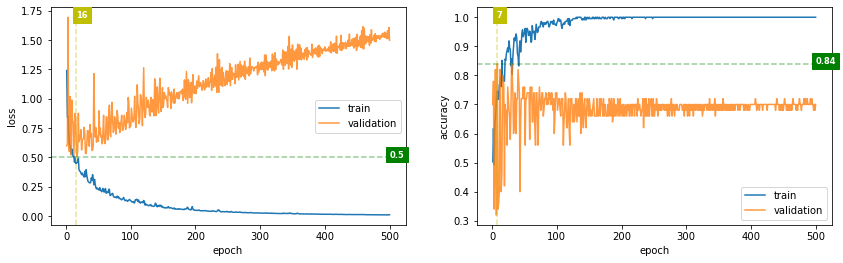

In [32]:
plot_train_log(history.history)

In [33]:
model.evaluate(train_x, train_y)

7/7 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 1.0000


[0.009275441989302635, 1.0]

In [34]:
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 3ms/step - loss: 1.4966 - accuracy: 0.7000


[1.4965626001358032, 0.699999988079071]

### using CNN

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_catvnoncat_data()
# Standardize data to have feature values between 0 and 1.
train_x = train_x_orig/255.
test_x = test_x_orig/255.
train_y = train_y.T
test_y = test_y.T
assert( train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0])

print ("train_x's shape: ", train_x.shape)
print ("test_x's shape: ", test_x.shape)

In [ ]:
from tensorflow.keras.layers import Conv2D # to add convolutional layers
from tensorflow.keras.layers import MaxPooling2D # to add pooling layers
from tensorflow.keras.layers import Flatten # to flatten data for fully connected layers

In [ ]:
# create model
model = Sequential()
model.add(Conv2D(8, (5, 5), strides=(1, 1), padding='valid', activation='relu', input_shape=train_x.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [ ]:
%%time
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=10, verbose=2)

# Tensorflow <a class='anchor' id='tensorflow'></a>

## Cat vs. not Cat example